In [1]:
import pandas as pd
from pandas import DataFrame
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
from sklearn.preprocessing import scale
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
import statsmodels.formula.api as sm
from statsmodels.compat import lzip
import numpy as np
import statsmodels.api as sm
from plotly.plotly import plot_mpl
from plotly.offline import init_notebook_mode, iplot_mpl

# MODELING AND FORECASTING SUB-SAHARAN GDP per capita PPP using ARIMA models

     “Prediction is very difficult, especially about the future”. Niels Bohr

*Following the Box-Jenkins methodology, we will build an Autoregressive Integrated Moving Average model to predict the Sub-Saharan GDP per capita (PPP), according to the ARIMA recognition rules (stationary test, white gaussian noise residuals,..), under the AIC criterion. Using this optimzied ARIMA model, we'll generate a projection for the SSA GDP per capita in PPP to 2030. Finally, after building a second optimized ARIMA model to project the world GDPpc in PPP to 2030, we'll analize how the SSA projection fathoms with the world average. We will derive our own conclusions from the underlying chacracteristics of both projected time series, and analize which the structural transformation pattern needed for SSA to converge with the world average.*

### ARIMA models 

The publication in 1970 of Time Series Analysis: Forecasting and Control by Box and Jenkins, ushered a new generation of forecasting tools capabale to analize the stochastic properties of time series utilizing the underlying information in the data. 

With the underlying philosophy of *"leting the data speak for herself"*, the ARIMA acronym is very direct, capturing the key aspects of the model itself. Briefly :

- **AR: Autoregression**-> The evolving response variable is regressed on its own lagged prior values.

- **I: Integrated.**-> The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary. 
    
- **MA: Moving Average.**-> The MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past.

Each of these components have to be explicitly specified in the model as a parameter with standard notation of ARIMA(p,d,q) where the parameters are substituted with integer values which indicate the specific ARIMA model being used. The parameters are defined as follows:

- **p:** The number of lag observations included in the model, also called the lag order.

- **d:** The number of times that the raw observations are differenced, also called the degree of differencing.

- **q:** The size of the moving average window, also called the order of moving average.

Contrary to OLS linear regression, Arima models do not involve independent regressors, but rather they make use of the information in the time series itself to generate prediction. ARIMA models therefore, rely heavily on the underlying autocorrelation patterns in the data.

ARIMA models have proven themselves to be relatively robust especially when generating short-run forecasts.

**Box-Jenkins methodology**

The BJ methodology consists of four steps :
    
    1) Time series identification: In short, we have to find the appropiate values for p,d and q.
    2) Model estimation: After having identified the appropiate parameters of the ARIMA model. 
    3) Model diagnostic: We have to check that the model residuals follow a white noise distribution.
    4) Forecasting: We can project statistical predictive inference. 

### Data preparation

Unfortunately we only can account for 27 year observations, from 1990 to 2017 (very few SSA countries have reliable GDP per capita PPP data up to the 60s), which is short of the 50 recommended to build an ARIMA model based on the Box-Jenkins methodology of time series forecasting.

From the World Bank database, we have collected GDP PPP data for 27 years from 1990 to 2016. The sample is composed of 36 Sub-Saharan economies.

In [2]:
df2=pd.read_csv('../input/WDIData.csv')

In [3]:
df2=df2[(df2['Country Name'].str.contains('African|Benin|Burkina|Burundi|Cabo Verde|Cameroon|CAR|Chad|Comoros|Congo|Ivoire|Guinea|Eritrea|Eswatini|Ethiopia|Gambia|Ghana|Guinea|Guinea-Bissau|Kenya|Lesotho|Liberia|Madagascar|Malawi|Mali|Mauritania|Mauritius|Mozambique|Niger|Nigeria|Rwanda|Sao Tome|Senegal|Sierra Leone|South Sudan|Sudan|Tanzania|Togo|Uganda|Zambia|Zimbabwe')==True)]
df2['Indicator Name']=df2['Indicator Name'].str.replace('(',':').str.replace(')',':')
df2=df2[df2['Indicator Name'].str.contains("GDP per capita, PPP :current international")==True]
df2.index=df2['Country Name']
df2=df2[df2.index.str.contains('Sao Tome and Principe|South Sudan|Papua New Guinea|Equatorial Guinea|Mauritius')==False]
df2=df2.fillna(method='bfill',axis=1)
df2=df2.fillna(method='ffill',axis=1)
df2=df2.iloc[:,34:-2]
ts=df2.mean()
ts=pd.DataFrame(ts)
ts.columns=['GDP per capita']

## 1) Time series identification & exploratory analisys

**1.1 Time Series plot**

In [4]:
X=pd.to_datetime(ts.index)
y=ts['GDP per capita']
layout = go.Layout(title= 'Sub-Saharan African GDP per capita PPP 1990-2017 current international $',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20))
data = [go.Scatter(x=X,y=y)]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='heatmap',show_link=False)

From the time series figure above, the visual inspection of the time plot clearly indicates that Sub-Saharan GDP PPP per capita follows a **positive additive growth pattern.** The mean and the variance are clearly not constant. Therefore, we regard it as a non-stationary time series. *(further below we will discuss the importance of making the time series stationary for model building)*

In [5]:
ts_2=ts
ts_2['log_GDP_pc']=np.log(ts['GDP per capita'])
X=ts['log_GDP_pc'].index
y_1=ts['log_GDP_pc']
layout = go.Layout(title= 'Sub-Saharan African LOG GDP per capita PPP 1990-2017 current international $',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20),legend=dict(x=0.7, y=1))
trace0 = go.Scatter(x=X,y=y_1, mode = 'lines',name="SSA GDPpc PPP $ growth 1990-2017", marker = dict(size=12, color='red'))
data = [trace0]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='heatmap',show_link=False)

The "smoothing effect" of the log transformation is valuable both for making patterns of the data easy interpretable. The see that the log transformed time seriues follows the same growth dynamic as the original time series.

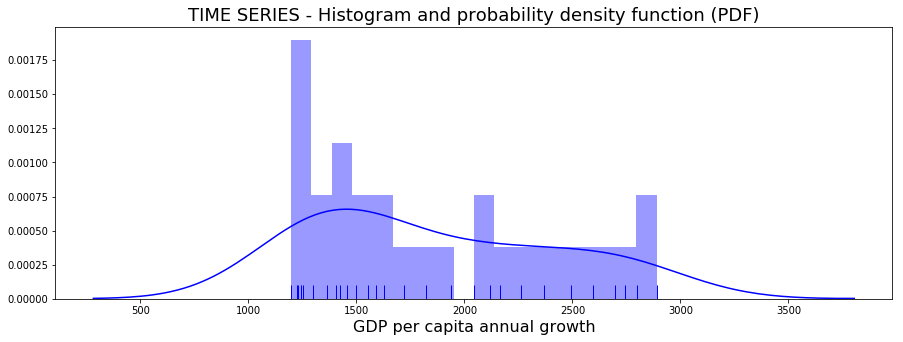

In [6]:
f, ax = plt.subplots(figsize=(15, 5)); plt.title('Distribution')
sns.distplot(ts['GDP per capita'],color='blue', bins=18,rug=True,hist_kws={"density":True})
plt.rc('xtick', labelsize=14)    # fontsize of the tick X labels 
plt.rc('ytick', labelsize=14)    # fontsize of the tick Y labels
plt.title('TIME SERIES - Histogram and probability density function (PDF)', size=18)
plt.xlabel('GDP per capita annual growth', size=16)
plt.show()

**1.2 Time Series growth dynamic examination**

In [7]:
ts_1=ts
ts_1['mean']=ts['GDP per capita'].pct_change().fillna(0).mean()
X=ts['GDP per capita'].index
y_2=ts['GDP per capita'].pct_change().fillna(0)
y1=ts_1['mean']
layout = go.Layout(title= 'Sub-Saharan African GDP per capita PPP growth dynamic 1990-2017 current international $',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20),legend=dict(x=0.7, y=1))
trace0 = go.Scatter(x=X,y=y_2, mode = 'lines',name="SSA GDPpc PPP $ growth 1990-2017", marker = dict(size=12, color='red'))
trace1 = go.Scatter(x=X,y=y1, mode = 'lines', name="TS Mean ", marker = dict(size=12, color='darkcyan'))
data = [trace0,trace1]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='heatmap',show_link=False)

Analyzing the growth dynamic of the time series; We can identify some cyclic patterns. Thus, from 1990 to 1994 the growth is the lowest of the series. From 1994 to 1996 we see growth accelearating, with a slowdown in 1998. From 1998 to 2007, growth reaccelerates progressively (expect for the period 2001-2003); reaching a peak in 2006  (6.16%) (pre-depression period). The post-depression dynamics are marked by a recovery of the growth rates (rates higher than series 3% average) with a sharp drop in 2015 (growth of 1.5%). As of this year, the recent period initiates a bullish tends towards the 3% average of the series.

In [8]:
returns1 = ts['GDP per capita'].pct_change().fillna(0)
ret_index_1 = (1+returns1).cumprod()
X_1=ret_index_1.index
y_1=ret_index_1.values
layout = go.Layout(title= 'Sub-Saharan African GDP per capita PPP 1990-2017 accumulative growth (Index 1=1990)',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20))
data = [go.Bar(x=X_1,y=y_1,marker =dict(color='lightsalmon'))]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='heatmap',show_link=False)

This indexed series (1990=1) gives us a good perspective on the cumulative growth dynamic of the series. We can identify a very regular trend.

**1.3 Time Series growth dynamic distribution examination**

In [9]:
trace1 = go.Box(
    y=ts['GDP per capita'].pct_change().fillna(0),
    name='Time series growth dynamic with Mean & SD',boxpoints='all',
    marker=dict(
        color='darkcyan',opacity=0.7),boxmean='sd')
data = [trace1]
layout = go.Layout(title='')
fig =go.Figure(data=data, layout=layout)
iplot(data)

The box-plot shows us visually the same indicators identified before.

In [10]:
fig = {"data": [{"type": 'violin', "y": y, "box": {"visible": True}, "line": {"color": 'black'},"meanline": 
                 {"visible": True },"fillcolor": 'darkcyan',"opacity": 0.7,"x0": 'Violin'}],
    "layout" : { "title": "Violin Plot - Time series growth dynamic", "yaxis": { "zeroline": False,}}}

fig =go.Figure(data=fig, layout=layout)
iplot(fig)

Violin plots are similar to histograms  in that they show an abstract representation of the probability distribution of the data, rather than showing counts of data points that fall into bins or order statistics, violin plots use the kernel density estimation (KDE) to compute an empirical distribution of the data.

The violin plot shows the presence of different peaks, their position and "relative amplitude". 

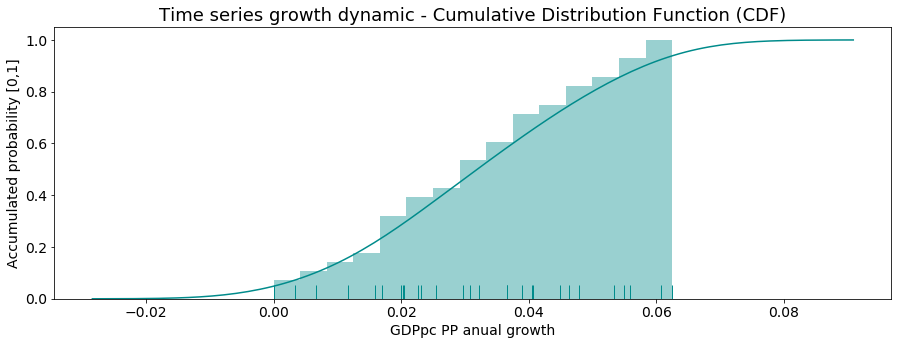

In [11]:
f, ax = plt.subplots(figsize=(15, 5)); plt.title('Distribution')
sns.distplot(ts['GDP per capita'].pct_change().fillna(0),bins=15, hist_kws={'cumulative': True},color='darkcyan', 
             kde_kws={'cumulative': True},rug=True)
plt.rc('xtick', labelsize=14)    # fontsize of the tick X labels 
plt.rc('ytick', labelsize=14)    # fontsize of the tick Y labels
plt.title('Time series growth dynamic - Cumulative Distribution Function (CDF)', 
          size=18)
SIZE2=12
plt.xlabel('GDPpc PP anual growth', size=14)
plt.ylabel('Accumulated probability [0,1]', size=14)
plt.show()

The cumulative distribution function (CDF) is the probability that the variable takes a value less than or equal to an certain X value. For instance, we see that the probability that a given time series year reports GDPpc growth < 3% is higher than 45%. 

- 75% of the years are compressed between a growth of 1.8% and 4.6%. 
- Only 25% of the years registered growth higher than 4.6%.

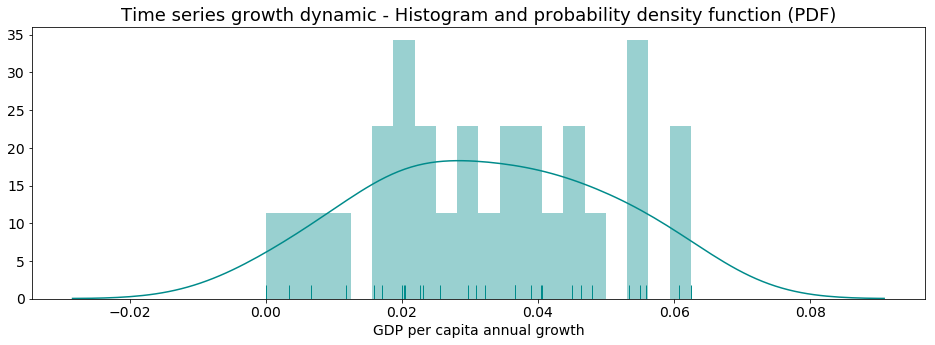

In [12]:
f, ax = plt.subplots(figsize=(16, 5)); plt.title('Distribution')
sns.distplot(ts['GDP per capita'].pct_change().fillna(0),color='darkcyan', bins=20,rug=True,hist_kws={"density":True})
plt.rc('xtick', labelsize=SIZE2)    # fontsize of the tick X labels 
plt.rc('ytick', labelsize=SIZE2)    # fontsize of the tick Y labels
plt.title('Time series growth dynamic - Histogram and probability density function (PDF)', size=18)
plt.xlabel('GDP per capita annual growth', size=14)
plt.show()

As expected we see a very **asymetric distribution with a long right side tail.**

**1.4 ACF (Auto Correlation Function Plot) & PACF (Partial Auto Correlation Function Plot)**

The first test of stationarity has to be autocorrelation function ACF.  

The ACF at lag k denoted as :

$$ p_k = covarience_k  /  variance $$

Where we have each observation covariance at lag k. As both the variance and the covariance are measured in the same units of measurement the autocorrelation function is unitless and it lies between -1 and 1 as any other correlation coeficient. 

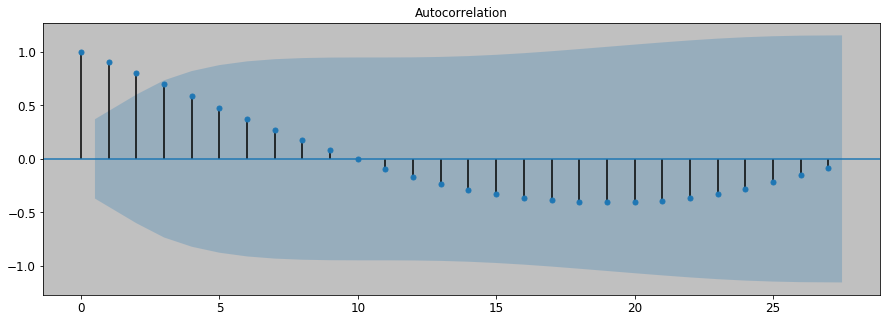

In [13]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
sm.graphics.tsa.plot_acf(y,ax=ax,lags=27)
plt.show()

A visual examination of the correlogram to lag 27 confirms that the data is clearly non-stationary and follows an accumulative autoregressive growth pattern up to the 9th lag, and starts accumulating negative autocorrelation from the 10th lag onward.  It is the expected result for a growing additive time series, with no sesonality. The blue margin shows the 95% confidence interval. 

**Concept of Stationarity :**

*A stochastic process is called strongly stationary if the distribution of original time series is exactly the same as its lagged versions. So the the distribution of the time series is unchanged for any abritrary shift in time.*

*This assumption, however, doesn't apply to real time series and a milder assumption enters the picture, covariance stationarity. This just means that the mean and variance of the series should not be a function of time (they have to be finite and independent of time) and that the  autocovariance between time points and is also finite and only depends on the distance between the two points.* 

*Why is making our time series stationary important? If our series is consistently increasing/decreasing over time, it means that either the mean is not constant or the variance-autocovariances are time-dependent, which makes more difficult to develop mathematical theory and models for time series. In summary, we can only study the series patterns for the given period and we cannot build generalized predictive ARIMA models with it*.

Gaussian white noise:
    $$ U_t \sim N(0,1) $$

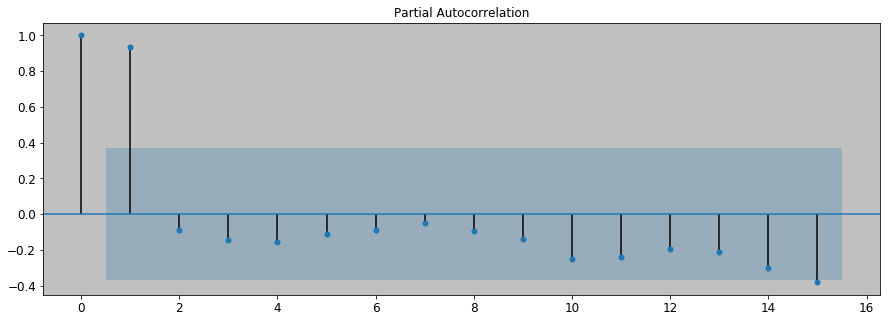

In [14]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
sm.graphics.tsa.plot_pacf(y,ax=ax)
plt.show()

Partial autocorrelation is as the correlation between the series and its lag, excluding the contributions from the intermediate lags. PACF conveys the pure correlation between a lag and the series. 

**1.5 Rolling Mean, Std and Dickey-Fuller Test:**

Altought by visualizing the time series it is fairly easy to identify a changing mean or variation in the data, for a more accurate stationary assessment we have to undertake the Dickey-Fuller test. 

In [15]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.rc('xtick', labelsize=8); plt.rc('ytick', labelsize=16) 
    plt.xticks([])
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

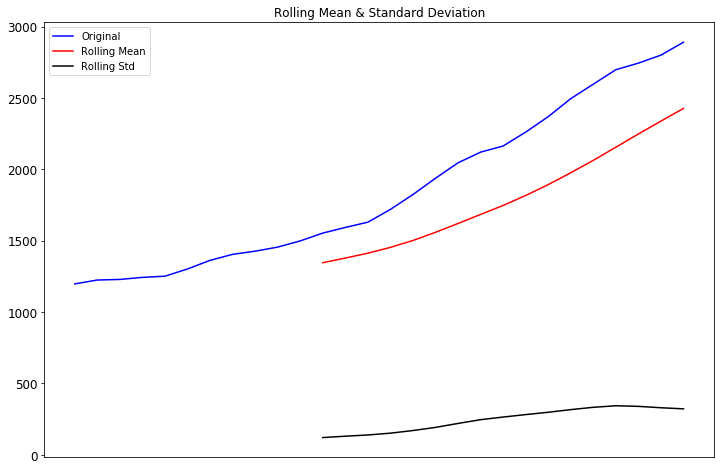

Results of Dickey-Fuller Test:
Test Statistic                  1.130828
p-value                         0.995471
#Lags Used                      1.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64


In [16]:
test_stationarity(y)

 Judging from the rolling mean plot, it is evident that there is a trend in the data and that the data is not trend stationary. 
 
 The result of the Dickey-Fuller Test also confirms it.

**1.6 Time series decomposition**

The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. We will use an additive model as it seems we are dealing with a liniar trend fairly constant over time. A multiplicative model is more appropriate when we are increasing (or decreasing) at a non-linear rate.

However, based off the previous charts, it looks like the trend in some periods is slightly increasing at a higher rate than just linear.

In [17]:
ts.index = pd.to_datetime(ts.index)
from statsmodels.tsa.seasonal import seasonal_decompose

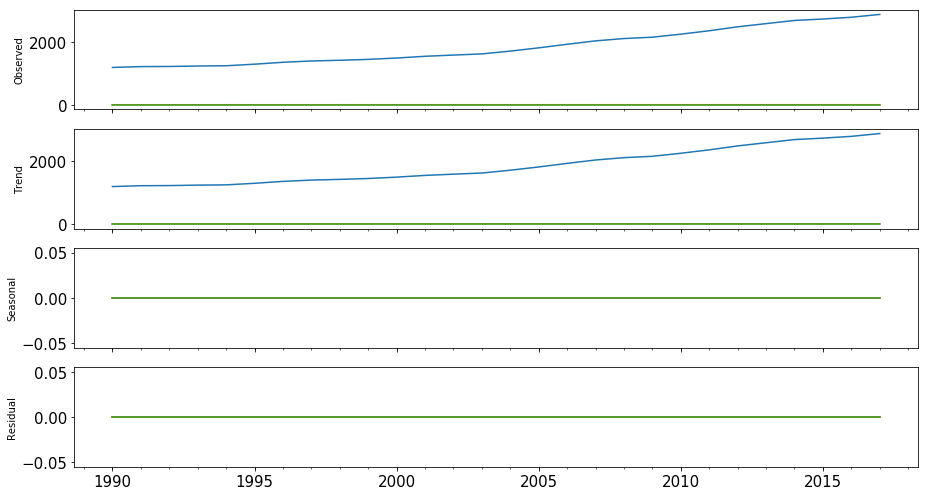

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
SIZE2=15  
plt.rc('xtick', labelsize=SIZE2)    # fontsize of the tick X labels 
plt.rc('ytick', labelsize=SIZE2)    # fontsize of the tick Y labels
decomposition = seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

Our time series separated into its trend, seasonal, and residual components. As our time series is anual, we can discard any kind of seasonality. We can discard also any underlying pattern in the residuals.


### 2) Stationarize the time series
We need to transform the data to make it stationary. 

**2.1 First-Order Difference**

We assume that we can remove the trend/seasonality from our data using the first order differencing. 
(we take the first differences between values in the series, the order tells us how far apart these values are) Yt-Yt-1

In [19]:
# first order difference of the time series
y_diff = (y).diff().dropna()
y_diff = pd.Series(y_diff )

In [20]:
layout = go.Layout(title= 'Sub-Saharan African GDP First order differencing',
xaxis = dict(ticks='', nticks=43),
yaxis = dict(nticks=20),legend=dict(x=0.7, y=1))

trace0 = go.Scatter(x=y_diff.index, y=y_diff.values, mode = 'lines+markers',name="SSA GDPpc PPP $ growth 1990-2017", marker = dict(size=12, color='black'))
data = [trace0]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='heatmap',show_link=False)

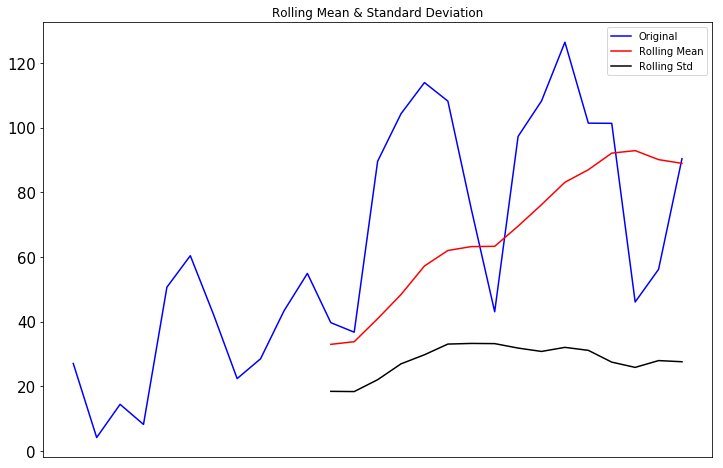

Results of Dickey-Fuller Test:
Test Statistic                 -1.963482
p-value                         0.302811
#Lags Used                      0.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64


In [21]:
test_stationarity(y_diff)

We see that our p value got a lot closer to 0.05, however, we still don't have a stationary series.

The application of the first difference  seems to have extracted quite well the trend as well and made the time series standard deviation stationary. However, the test statistic is still larger than the critical value for a significance level of 5%. 

**2.2 Second-Order Differencing**

As our differenced data is still not stationary another differencing step has to be included. This step indicates a higher order integration of the underlying process. We interpret the second level of differenced data as the “change of changes”. 

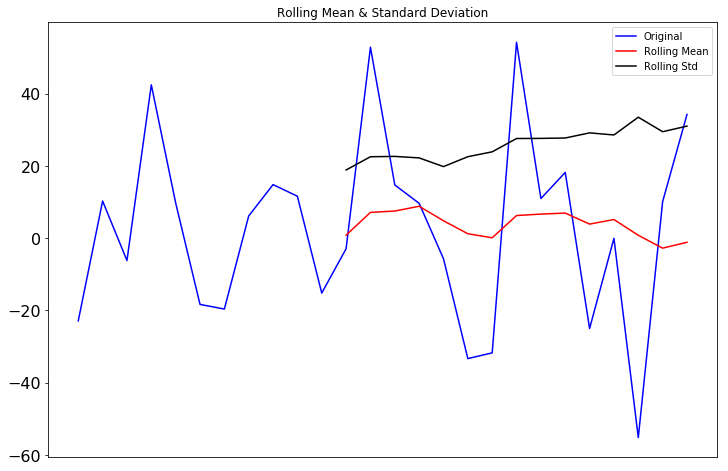

Results of Dickey-Fuller Test:
Test Statistic                 -4.116714
p-value                         0.000909
#Lags Used                      4.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


In [22]:
# log difference time series
y_diff2 = (y).diff().diff().dropna()
y_diff2 = pd.Series(y_diff2)
test_stationarity(y_diff2)

In [23]:
layout = go.Layout(title= 'Sub-Saharan African GDP Second order differencing', xaxis = dict(ticks='', nticks=43),yaxis = dict(nticks=20),legend=dict(x=0.7, y=1))
trace0 = go.Scatter(x=y_diff2.index, y=y_diff2.values, mode = 'lines+markers',name="SSA GDPpc PPP $ growth 1990-2017", marker = dict(size=12, color='black'))
data = [trace0]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='heatmap',show_link=False)

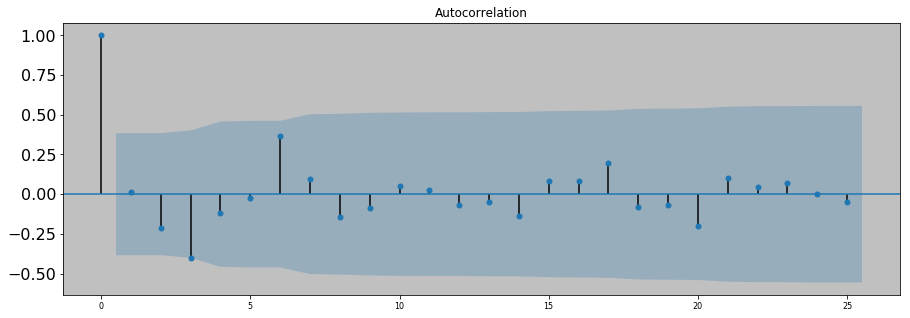

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
plt.rc('xtick', labelsize=16)
sm.graphics.tsa.plot_acf(y_diff2,ax=ax,lags=25)
plt.show()

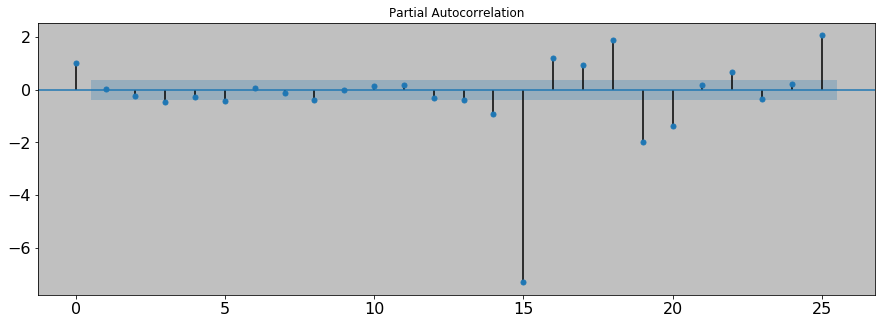

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
sm.graphics.tsa.plot_pacf(y_diff2,ax=ax, lags=25)
plt.show()

We see that the DF test statistic is already smaller that 1% percent significance. However, since there are spikes in the ACF and PACF plots which lie outsite the insignificant zone it can be concluded that the residuals are still not random. This implies that there is an information patterns left in the residuals which can be extracted by autoregressive and moving average models.

When looking at the PACF and ACF plot of the transformed second order differenced time series a significant spike in the residuals at lag 15 can be detected. This is an indication of an unusual component, which has not been extracted from the series completely.

### 3) ARIMA (p,d,q) model

To fit the time series data to an ARIMA model with parameters ARIMA(p, d, q) we need to find the optimal parameter setting that strips away the systematic information and leaves us with gaussian white  noise residuals. Thus for selecting, the best fitting model we iteratively generate different models with a given parameter combination and fit the data to it. For each of these models we compute the Akaike Information Criterion (AIC) and eventually choose the model for which the fitted data results in the lowest AIC. In this case, we want to choose a simple ARIMA model that generalizes well the behaviour of the series. 

**ORDER p**
- The PACF shows conveys the pure correlation between a lag and the series. Order 3 is the first above the significance line. We choose this value in order to keep the model as simple as possible.

**ORDER d**
- We already detected order of integration 2 in order to make the series stationary.

**ORDER q**
- Using ACF plot we can gauge the number of MA terms. An MA term is technically, the error of the lagged forecast. Order 3 is the first above the significance line; we choose this value in order to keep the model as simple as possible. 

**The Akaike Information Criterion**

The Akaike information criterion (AIC) is a measure of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Hence, AIC provides a means for model selection. AIC measures the trade-off between the goodness of fit of the model and the complexity of the model (number of included and estimated aprameters). The AIC is calculated as follows :

**AIC = 2k - 2ln(L)**

Where k corresponds to the number of estimated parameters in the model and L refers to the maximum value of the likelihood function for the model. The AIC only measures the in-sample model fit of the data.

In [26]:
mod = sm.tsa.statespace.SARIMAX(ts['GDP per capita'].values,order=(3,2,3),enforce_stationarity=True,enforce_invertibility=True, maxiter=1000, method='css')
results1 = mod.fit()
print(results1.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   28
Model:               SARIMAX(3, 2, 3)   Log Likelihood                -116.949
Date:                Wed, 17 Jul 2019   AIC                            247.899
Time:                        12:58:06   BIC                            256.705
Sample:                             0   HQIC                           250.435
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2793      0.730      0.383      0.702      -1.151       1.710
ar.L2          0.1739      0.713      0.244      0.807      -1.224       1.572
ar.L3         -0.7641      0.455     -1.681      0.0

**3.1 Diagnostic plots for standardized residuals**

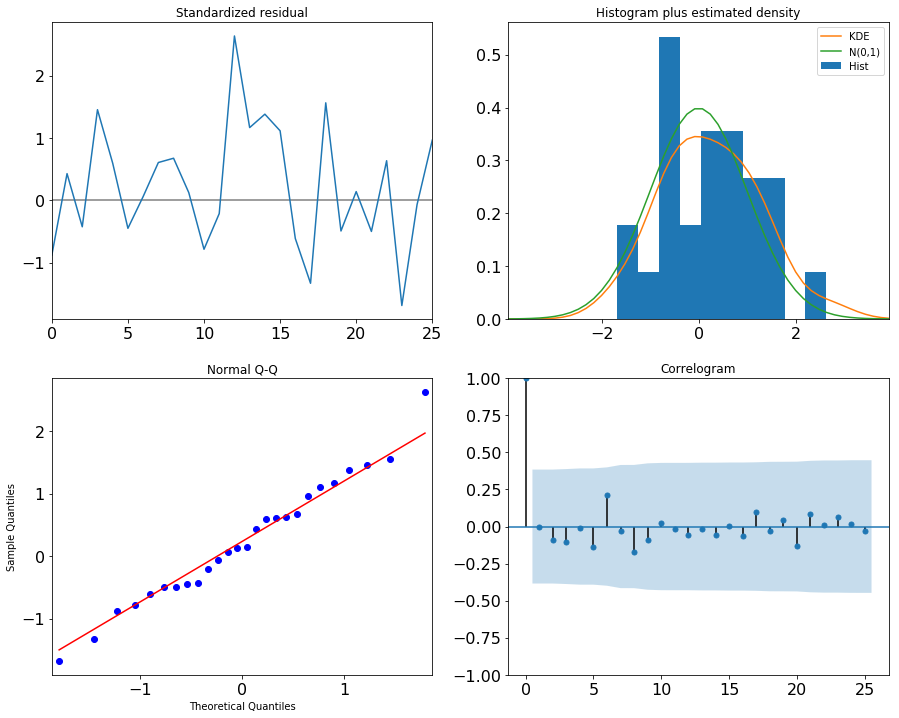

In [27]:
results1.plot_diagnostics(figsize=(15, 12),lags=25)
plt.show()

The standarized residual plot of the fitted model in the upper right corner appears to be white noise as it does not display any pattern. The histogram plot in the upper right corner pair with the kernel density estimation (orange line) indicates that the time series is almost normally distributed (green line) and aproximates **Gaussian White Noise.**


The correlogram (autocorrelation plot) confirms this resuts, since the time series residuals show low correlations with lagged residuals. There aren't any statistically significant peaks at 5% significance level. Hence we can state that the the correlogram looks like that of discrete white noise. 

We can conclude that the model is a good fit for our time series data. 

In [28]:
prediction_summary=results1.get_prediction(start=0, end=40).summary_frame()
prediction_summary.index=['1990-01-01', '1991-01-01','1992-01-01','1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01',
               '2024-01-01', '2025-01-01', '2026-01-01', '2027-01-01',
               '2028-01-01', '2029-01-01', '2030-01-01']

### 4) In-sample prediction and out-of-sample forecasting of SSA GDP per capita to 2030

In [29]:
forecast=results1.predict(start=0,end=40)
forecast=pd.DataFrame(forecast, columns = ['projection'])
forecast.index=['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017','2018','2019','2020','2021','2022','2023','2024','2025','2026','2027','2028','2029','2030']


In [30]:
# Create traces
trace0 = go.Scatter(
    x = ts.index,
    y = ts['GDP per capita'],
    mode = 'markers',
    name = 'Actual GDP PPP',marker = dict(size=7))
trace1 = go.Scatter(
    x = forecast.iloc[2:].index,
    y = forecast.iloc[2:].projection,
    mode = 'lines+markers',
    name = 'Arima model (5,2,0) in sample model & 2030 projection',marker = dict(size=7),opacity = 0.6)


layout = go.Layout(title= 'In-sample prediction and out-of-sample forecasting to 2030 per capita - GDP PPP US$ SSA',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20), legend=dict(x=0.1, y=1))
data = [trace0, trace1]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='scatter-mode')

In [31]:
# Create traces
trace0 = go.Scatter(
    x = ts.index,
    y = ts['GDP per capita'],
    mode = 'markers',
    name = 'Actual GDP PPP',marker = dict(size=7))


trace2 =go.Scatter(x=prediction_summary.iloc[2:].index, y=prediction_summary.iloc[2:].mean_ci_lower.values, name='ARIMA model 95% Lower CI', mode = 'lines',
                   marker = dict(size=10, color='red'),opacity = 0.3)

trace3 =go.Scatter(x=prediction_summary.iloc[2:].index, y=prediction_summary.iloc[2:].mean_ci_upper.values,name='ARIMA model 95% Upper CI', mode = 'lines',
                   marker = dict(size=10, color='red'),opacity = 0.3)

trace4 =go.Scatter(x=prediction_summary.iloc[28:].index, y=prediction_summary.iloc[28:]['mean'].values,name='ARIMA model mean projected values', mode = 'markers',
                   marker = dict(size=10, color='red'),opacity = 0.3)

layout = go.Layout(title= 'In-sample prediction and out-of-sample forecasting 95% CI - GDPpc PPP US$ SSA',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20), legend=dict(x=0.1, y=1))
data = [trace0,trace2,trace3,trace4]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='scatter-mode')

We see that our in sample performance shows very strong alignment, and apart from the start of the series, our relative error is within the range of 95% confidence interval, which is relatively strong. Our ARIMA (3,2,3) model predicts that **without any underlying economic structural change**; at the current growth patterns, the GDP per capita in SSA will only surpass the 4.000 US dollars barrier by 2030.

We have to account that the forecasting results of this model are only predicted values, accounting for the underlying structure of the Time Series over the last 24 years.

### 5) Times series comparison with the world average

**5.1 Data Preparation**

In [32]:
df3=pd.read_csv('../input/WDIData.csv')
df3=df3[df3['Country Name']=='World']
df3['Indicator Name']=df3['Indicator Name'].str.replace('(',':').str.replace(')',':')
df3=df3[df3['Indicator Name'].str.contains("GDP per capita, PPP :current international")==True]
df3.index=df3['Country Name']
df3=df3.dropna(axis=1)
df3.drop(['Country Name','Country Code','Indicator Name','Indicator Code'], axis=1, inplace=True)
ts2=df3 ; ts2=ts2.T
ts2.index = pd.to_datetime(ts2.index)
ts2.columns=['GDP per capita']
ts2['world_percentatge']=ts['GDP per capita']/ts2['GDP per capita']

**5.2 World Time series identification & exploratory analisys**

In [33]:
layout = go.Layout(title= 'World & SSA GDP per capita PPP constant $ 1990-2017',
xaxis = dict(ticks='', nticks=43),
yaxis = dict(nticks=20), legend=dict(x=0.1, y=1))
trace0 =go.Scatter(x=ts2.index, y=ts2['GDP per capita'],
                   name='World GDP per capita PPP TS 1990-2017', marker = dict(size=12, color='green'))
trace1 =go.Scatter(x=ts.index,y=ts['GDP per capita'],
                   name='SSA GDP per capita PPP TS 1990-2017',marker = dict(size=12, color='blue'))
data = [trace0]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='heatmap',show_link=False)

Altought both series are stationary,while  the World GDP per capita shows a much more exponential growth pattern, SSA follows a more constant additive growth pattern.

**5.3 Growth distribution of both TS**

In [34]:
trace1 = go.Box(
    y=ts['GDP per capita'].pct_change().fillna(0),
    name='SSA GDPpc growth TS',
    marker=dict(
        color='blue'),boxmean='sd')

trace2 = go.Box(
    y=ts2['GDP per capita'].pct_change().fillna(0),
    name='World GDPpc growth TS',
    marker=dict(
        color='green'),boxmean='sd')
data = [trace1,trace2]
fig =go.Figure(data=data, layout=layout)
iplot(data)

With a median value of 4%, the world TS accumulates higher % growth. Standard deviation is very similar in both series.

In [35]:
SSA_growth=ts['GDP per capita'].pct_change().fillna(0)
World_growth=ts2['GDP per capita'].pct_change().fillna(0)

In [36]:
layout = go.Layout(title= 'SSA vs World GDP per capita PPP growth % 1990-2017',
    xaxis = dict(ticks='', nticks=43), yaxis = dict(nticks=20),legend=dict(x=0.1, y=1))

trace0 =go.Scatter(x=ts.index, y=SSA_growth*100, name='SSA GDP per capita PPP anual growth', mode = 'markers+lines',
                   marker = dict(size=12, color='blue'))

trace1 =go.Scatter(x=ts2.index, y=World_growth*100,name='World GDP per capita PPP anual growth', mode = 'markers+lines',
                   marker = dict(size=12, color='green'))
data = [trace0, trace1]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='heatmap',show_link=False)

The world GDP per capita presents higher growth in almost all years of the time series, except 1996, 2009 with the effects of the great depression and 2014.

**5.4 SSA total GDPpc PPP as a % of the World average 1990-2017**

In [37]:
ts2['world_percentatge']=ts/ts2
layout = go.Layout(title= 'SSA GDP per capita PPP annual ratio with the world average 1990-2017',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20))
trace0 =go.Scatter(x=ts2.index, y=ts2['world_percentatge'],
                   mode = 'markers+lines',marker = dict(size=12, color='coral'))
data = [trace0]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='heatmap',show_link=False)

- We can see how since 1990 there has been a growing divergence of the SSA GDP per capita PPP and the world average. 


- While in 1990 SSA GDP per capita was around 20% of the world average, in 2017 it only represented around 15%. In these 24 years SSA Africa has diverged 5 points from the world average.

** 5.5 Arima modeling World GDP per capita PPP **

In [38]:
ts2.index = pd.to_datetime(ts2.index)

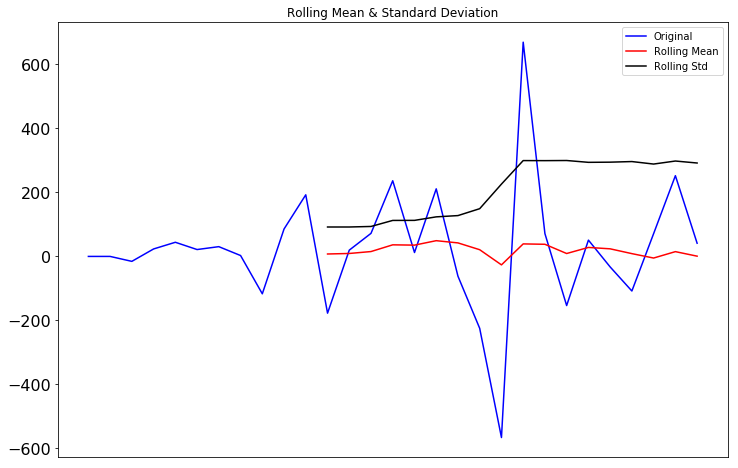

Results of Dickey-Fuller Test:
Test Statistic                 -4.390898
p-value                         0.000308
#Lags Used                      4.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


In [39]:
# log difference time series
ts2_diff2 = ((ts2['GDP per capita']).diff().diff().fillna(0))
ts2_diff2 = pd.Series(ts2_diff2)
test_stationarity(ts2_diff2)

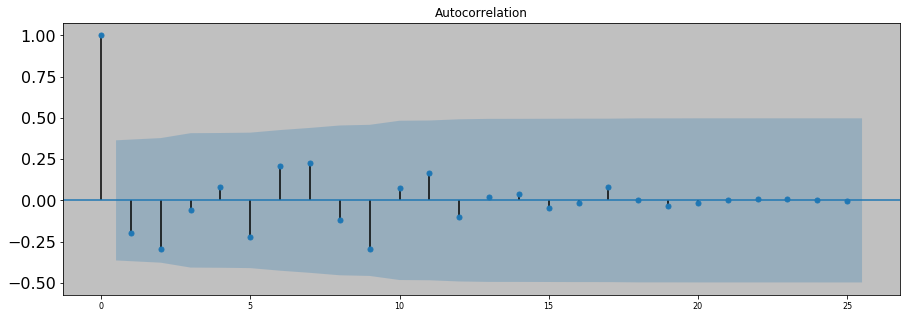

In [40]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_facecolor('silver')
sm.graphics.tsa.plot_acf(ts2_diff2,ax=ax, lags=25)
plt.show()

**ARIMA (0,2,2) world model**

AIC different ARIMA models with pm.auto_arima (not usable in Kaggle) :

    Fit ARIMA: order=(1, 2, 1); AIC=nan, BIC=nan, Fit time=nan seconds
    Fit ARIMA: order=(0, 2, 0); AIC=367.759, BIC=370.351, Fit time=0.016 seconds
    Fit ARIMA: order=(1, 2, 0); AIC=368.733, BIC=372.620, Fit time=0.031 seconds
    Fit ARIMA: order=(0, 2, 1); AIC=361.559, BIC=365.447, Fit time=0.016 seconds
    Fit ARIMA: order=(0, 2, 2); AIC=360.588, BIC=365.771, Fit time=0.187 seconds
    Fit ARIMA: order=(1, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
    Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
    Fit ARIMA: order=(0, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds

We choose the ARIMA (0,2,2) as the best fit to model the world GDP per capita time-series. 

**5.6 Diagnostic plots for standardized residuals**

In [41]:
mod = sm.tsa.statespace.SARIMAX((ts2['GDP per capita']), order=(0,2,2),
                                enforce_stationarity=True, enforce_invertibility=True,)
results2 = mod.fit()
print(results2.summary())

                           Statespace Model Results                           
Dep. Variable:         GDP per capita   No. Observations:                   29
Model:               SARIMAX(0, 2, 2)   Log Likelihood                -179.083
Date:                Wed, 17 Jul 2019   AIC                            364.167
Time:                        12:58:12   BIC                            368.054
Sample:                    01-01-1990   HQIC                           365.323
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3746      0.176     -2.128      0.033      -0.720      -0.030
ma.L2         -0.2957      0.135     -2.193      0.028      -0.560      -0.031
sigma2      3.317e+04   7761.812      4.274      0.0

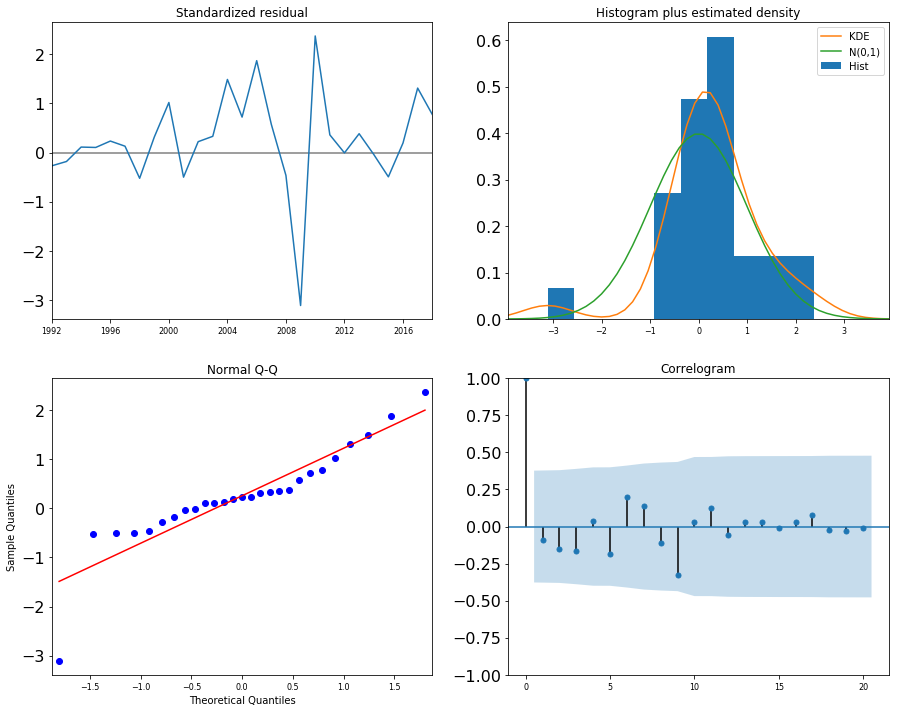

In [42]:
results2.plot_diagnostics(figsize=(15, 12),lags=20)
plt.show()

- The (0, 2, 2) ARIMA model fitted is adequate since the standardized residuals show a white gaussian noise pattern and fluctuate around 0.

- 2009, (the year that the great depression struck the hardest), represents a huge outlier, however, even if it doesn't bring any underlying information behaviour to the model, we cannot omit this year to simplify the modeling procedure (stationary & discrete white noise residuals) because with such small sample, the predictive accuracy of the model would be compromised. Altought we have not been able to extract information about this "unusual component" the predictive value of the model remains intact. 

- We can get to the same conclusions as with the SSA time series and we conclude that the residuals follow and aproximates Gaussian White Noise trend. At 20 lags the correlogram doesn't show any significant peak higher than 5% significance level. Hence we can state that the the correlogram is discrete white noise.

In [43]:
prediction_summary2=results2.get_prediction(start=0, end=40).summary_frame()
prediction_summary2.index=['1990-01-01', '1991-01-01','1992-01-01','1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
               '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01',
               '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01',
               '2024-01-01', '2025-01-01', '2026-01-01', '2027-01-01',
               '2028-01-01', '2029-01-01', '2030-01-01']

**5.7 In sample prediction and out of sample forecast**

In [44]:
forecast2=results2.predict(start=2,end=40)

forecast1=results1.predict(start=0,end=40)

# Create traces
trace0 = go.Scatter(
    x = ts.index,
    y = ts['GDP per capita'],
    mode = 'markers',
    name = 'SSA Actual GDP PPP',marker = dict(size=7))

trace1 = go.Scatter(
    x = forecast.iloc[2:].index,
    y = forecast.iloc[2:].projection,
    mode = 'lines',
    name = 'SSA Arima model (5,2,0) prediction',marker = dict(size=7),opacity = 0.5)

# Create traces
trace2 = go.Scatter(
    x = ts2.index,
    y = ts2['GDP per capita'],
    mode = 'markers',
    name = 'World Actual GDP PPP',marker = dict(size=7))


trace3 = go.Scatter(
    x = forecast2.index,
    y = forecast2.values,
    mode = 'lines',
    name = 'World Arima model (0,2,1) prediction',marker = dict(size=7),opacity = 0.5)


layout = go.Layout(title= 'In-sample prediction and out-of-sample projection to 2030 (GDPpc PPP US$) SSA & WA',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20), legend=dict(x=0.1, y=1))

data = [trace0, trace1,trace2,trace3]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='scatter-mode')

In [45]:
forecast
# Create traces
trace0 = go.Scatter(
    x = ts.index,
    y = ts['GDP per capita'],
    mode = 'markers',
    name = 'Actual GDP PPP',marker = dict(size=7))


trace2 =go.Scatter(x=prediction_summary.iloc[2:].index, y=prediction_summary.iloc[2:].mean_ci_lower.values, name='95% CI', mode = 'lines',
                   marker = dict(size=10, color='red'),opacity = 0.3)

trace3 =go.Scatter(x=prediction_summary.iloc[2:].index, y=prediction_summary.iloc[2:].mean_ci_upper.values, name='95% CI', mode = 'lines',
   marker = dict(size=10, color='red'),opacity = 0.3)

# Create traces
trace4 = go.Scatter(
    x = ts2.index,
    y = ts2['GDP per capita'],
    mode = 'markers',
    name = 'World Actual GDP PPP',marker = dict(size=7,color='green'))

trace5 =go.Scatter(x=prediction_summary2.iloc[2:].index, y=prediction_summary2.iloc[2:].mean_ci_lower.values, name='95% CI', mode = 'lines',
                   marker = dict(size=10, color='red'),opacity = 0.3)

trace6 =go.Scatter(x=prediction_summary2.iloc[2:].index, y=prediction_summary2.iloc[2:].mean_ci_upper.values, name='95% CI', mode = 'lines',
                   marker = dict(size=10, color='red'),opacity = 0.3)


layout = go.Layout(title= 'In-sample prediction and out-of-sample projection to 2030 95% CI (GDPpc PPP US$) SSA & WA',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20), legend=dict(x=0.1, y=1))
data = [trace0,trace2,trace3,trace4,trace5,trace6]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='scatter-mode')

In [46]:
trace5 =go.Scatter(x=prediction_summary2.iloc[2:].index, y=prediction_summary2.iloc[2:].mean_ci_lower.values, name='95% CI', mode = 'lines',
                   marker = dict(size=10, color='red'),opacity = 0.3)

trace6 =go.Scatter(x=prediction_summary2.iloc[2:].index, y=prediction_summary2.iloc[2:].mean_ci_upper.values, name='95% CI', mode = 'lines',
                   marker = dict(size=10, color='red'),opacity = 0.3)


**5.8 Future prediction SSA total GDPpc PPP as a % of the World average 2018-2030**

In [47]:
ts2['world_percentatge']=ts/ts2
future_ratio=results1.predict(start=27,end=40)/results2.predict(start=27,end=40)

ratio_l_CI=prediction_summary.iloc[2:28].mean_ci_lower/prediction_summary2.iloc[2:28].mean_ci_lower
ratio_h_CI=prediction_summary.iloc[2:28].mean_ci_upper/prediction_summary2.iloc[2:28].mean_ci_upper
future_ratio_l_CI=prediction_summary.iloc[27:].mean_ci_lower/prediction_summary2.iloc[27:].mean_ci_lower
future_ratio_h_CI=prediction_summary.iloc[27:].mean_ci_upper/prediction_summary2.iloc[27:].mean_ci_upper
layout = go.Layout(title= 'SSA GDPpc PPP as a ratio of the World average future prediction to 2030',
    xaxis = dict(ticks='', nticks=43),
    yaxis = dict(nticks=20),legend=dict(x=0.7, y=1))

trace0 =go.Scatter(x=ts2.index, y=ts2['world_percentatge'],
                   mode = 'markers',name = '1990-2017 actual ratio', marker = dict(size=12, color='coral'),opacity=0.8)
trace10 =go.Scatter(x=future_ratio.index, y=future_ratio,
                   mode = 'markers',name = 'predicted ratio', marker = dict(size=12, color='red'),opacity=0.5)
trace5 =go.Scatter(x=ratio_l_CI.index, y=ratio_l_CI.values,
                   mode = 'lines',name = '2017-2030 actual ratio 95% CI', marker = dict(size=10, color='black'),opacity = 0.8)

trace6 =go.Scatter(x=ratio_h_CI.index, y=ratio_h_CI.values,
                   mode = 'lines',name = '2017-2030 actual ratio 95% CI', marker = dict(size=10, color='black'),opacity = 0.8)
trace2 =go.Scatter(x=future_ratio_l_CI.index, y=future_ratio_l_CI.values,
                   mode = 'lines',name = '2017-2030 projected ratio 95% CI', marker = dict(size=10, color='red'),opacity = 0.5)
trace3 =go.Scatter(x=future_ratio_h_CI.index, y=future_ratio_h_CI.values,
                   mode = 'lines',name = '2017-2030 projected ratio 95% CI', marker = dict(size=10, color='red'),opacity = 0.5)
data = [trace0,trace2,trace3,trace10,trace5,trace6]
fig =go.Figure(data=data, layout=layout)
iplot(fig, filename='heatmap',show_link=False)

### Conclusions

Taking into account the underlying patterns of both time series, without a structural change in the regional GDPpc time series, SSA will continue being the underdog of the global economy for the next decade and the divergence with the world average is only likely to increase. Our model indicates that if the current underlying trends are to continue, the regional GDPpc as a percentatge of the world average will decrease to around 15% at the end of the 30s decade from the current value of around 17%. The current structural trend of the region’s GDPpc growth remains weak. A much more explosive growth pattern is highly needed to converge with the world average. Returning to pre-crisis levels of around 5% growth would bring the region in the convergence world average path.

Altough, its true that the region is experiencing a much explosive population growth than the rest of the world; it also departs from a much lower position, which allows to accumulate higher scaled levels of economic output.

Many economists suggest that SSA is too resourced-focus and manufacture-absent, which historical data tells it is the "standard model" followed by the majority of countries to have successfully transitioned from low-to middle or high income status. It's also true that western agricultural and commercial policies are still very damaging to SSA economic interests, but the region will only converge with the world average if decisive "game-changing" socio-economic and institutional reforms are implemented. Regarding the later, the Ethiopian example, one of the poorest countries in the world in 2000 and now one of the fastest-growing economies in the world, sheds some light, into the path to follow for the most vulnerable nations.

Note: We have to remember, that the forecasting result of these model are only predicted values. The economy is complex and dynamic system. The adjustments of macro and investment policy, institutional integrity and environment, social stability, plus other numerous internal external and internal factors can cause drastic changes in terms of GDP per capita growth in any region of the world.